<a href="https://colab.research.google.com/github/Gaurav1401/Credit_Risk_Modelling/blob/main/Credit_Risk_Scorecard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sms
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import probit,logit
import pandas.util.testing as tm
from sklearn.metrics import f1_score, roc_auc_score, recall_score

import warnings as wg
from math import pi
wg.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  # This is added back by InteractiveShellApp.init_path()


In [2]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# py_mob/py_mob.py
# exec(open('py_mob/py_mob.py').read())
# version 0.3

# The below code has been taken from pymob official directory
import pandas, numpy, scipy.stats, sklearn.isotonic, sklearn.cluster, lightgbm
import tabulate, pkg_resources


def get_data(data):
  """
  The function loads a testing dataset.

  Parameters:
    data : The name of dataset. It is either "hmeq" or "accepts", both of
           which are loan performance data.

  Returns:
    A dict with the dataset.

  Example:
    data = py_mob.get_data("accepts")

    data.keys()
    # ['bankruptcy', 'bad', 'app_id', 'tot_derog', 'tot_tr', 'age_oldest_tr',
    #  'tot_open_tr', 'tot_rev_tr', 'tot_rev_debt', 'tot_rev_line', 'rev_util',
    #  'bureau_score', 'purch_price', 'msrp', 'down_pyt', 'purpose', 
    #  'loan_term', 'loan_amt', 'ltv', 'tot_income', 'used_ind', 'weight']
  
    py_mob.view_bin(py_mob.qtl_bin(data["ltv"], data["bad"]))
  """

  _p = pkg_resources.resource_filename("py_mob", "data/" + data + ".csv")

  _d = numpy.recfromcsv(_p, delimiter = ',', names = True, encoding = 'latin-1')

  return(dict((_2, [_[_1] for _ in _d]) for _1, _2 in enumerate(_d.dtype.fields)))


########## 01. cal_woe() ########## 

def cal_woe(x, bin):
  """
  The function applies the woe transformation to a numeric vector based on 
  the binning outcome.

  Parameters:
    x   : A numeric vector, which can be a list, 1-D numpy array, or pandas 
          series
    bin : An object containing the binning outcome.

  Returns:
    A list of dictionaries with three keys

  Example:
    ltv_bin = py_mob.qtl_bin(ltv, bad)

    for x in cal_woe(ltv[:3], ltv_bin):
      print(x)

    # {'x': 109.0, 'bin': 6, 'woe': 0.2694}
    # {'x':  97.0, 'bin': 3, 'woe': 0.0045}
    # {'x': 105.0, 'bin': 5, 'woe': 0.1829}
  """

  _cut = sorted([_ for _ in bin['cut']] + [numpy.PINF, numpy.NINF])

  _dat = [[_1[0], _1[1], _2] for _1, _2 in zip(enumerate(x), ~numpy.isnan(x))]

  _m1 = [_[:2] for _ in _dat if _[2] == 0]
  _l1 = [_[:2] for _ in _dat if _[2] == 1]

  _l2 = [[*_1, _2] for _1, _2 in zip(_l1, numpy.searchsorted(_cut, [_[1] for _ in _l1]).tolist())]

  flatten = lambda l: [item for subl in l for item in subl]
 
  _l3 = flatten([[[*l, b['woe']] for l in _l2 if l[2] == b['bin']] for b in bin['tbl'] if b['bin'] > 0])

  if len(_m1) > 0:
    if len([_ for _ in bin['tbl'] if _['miss'] > 0]) > 0:
      _m2 = [l + [_['bin'] for _ in bin['tbl'] if _['miss'] > 0] 
               + [_['woe'] for _ in bin['tbl'] if _['miss'] > 0] for l in _m1]
    else:
      _m2 = [l + [0, 0] for l in _m1]
    _l3.extend(_m2)

  _key = ["x", "bin", "woe"]

  return(list(dict(zip(_key, _[1:])) for _ in sorted(_l3, key = lambda x: x[0])))


########## 02. summ_bin() ########## 

def summ_bin(x):
  """
  The function summarizes the binning outcome generated from a binning function, 
  e.g. qtl_bin() or iso_bin().

  Parameters:
    x: An object containing the binning outcome.

  Returns:
    A dictionary with statistics derived from the binning outcome

  Example:
    py_mob.summ_bin(py_mob.iso_bin(ltv, bad))
    # {'sample size': 5837, 'bad rate': 0.2049, 'iv': 0.185, 'ks': 16.88, 'missing': 0.0002}
  """

  _freq = sum(_['freq'] for _ in x['tbl'])
  _bads = sum(_['bads'] for _ in x['tbl'])
  _miss = sum(_['miss'] for _ in x['tbl'])

  _iv = round(sum(_['iv'] for _ in x['tbl']), 4)
  _ks = round(max(_["ks"] for _ in x["tbl"]), 2)

  _br = round(_bads / _freq, 4)
  _mr = round(_miss / _freq, 4)

  return({"sample size": _freq, "bad rate": _br, "iv": _iv, "ks": _ks, "missing": _mr})


########## 03. view_bin() ########## 

def view_bin(x):
  """
  The function displays the binning outcome generated from a binning function, 
  e.g. qtl_bin() or iso_bin().

  Parameters:
    x: An object containing the binning outcome.

  Returns:
    None

  Example:
    py_mob.view_bin(py_mob.qtl_bin(df.ltv, df.bad))
  """

  tabulate.PRESERVE_WHITESPACE = True

  _sel = ["bin", "freq", "miss", "bads", "rate", "woe", "iv", "ks"]

  _tbl = [{**(lambda v: {k: v[k] for k in _sel})(_), "rule": _["rule"].ljust(45)} for _ in x["tbl"]]

  print(tabulate.tabulate(_tbl, headers = "keys", tablefmt = "github", 
                          colalign = ["center"] + ["right"] * 7 + ["center"],
                          floatfmt = (".0f", ".0f", ".0f", ".0f", ".4f", ".4f", ".4f", ".2f")))


########## 04. qcut() ##########

def qcut(x, n):
  """
  The function discretizes a numeric vector into n pieces based on quantiles.

  Parameters:
    x: A numeric vector.
    n: An integer indicating the number of categories to discretize.

  Returns:
    A list of numeric values to divide the vector x into n categories.

  Example:
    py_mob.qcut(range(10), 3)
    # [3, 6]
  """

  _q = numpy.linspace(0, 100, n, endpoint = False)[1:]
  _x = [_ for _ in x if not numpy.isnan(_)]
  _c = numpy.unique(numpy.percentile(_x, _q, interpolation = "lower"))
  return([_ for _ in _c])


########## 05. manual_bin() ##########

def manual_bin(x, y, cuts):
  """
  The function discretizes the x vector and then summarizes over the y vector
  based on the discretization result.

  Parameters:
    x    : A numeric vector to discretize without missing values, 
           e.g. numpy.nan or math.nan
    y    : A numeric vector with binary values of 0/1 and with the same length 
           of x
    cuts : A list of numeric values as cut points to discretize x.

  Returns:
    A list of dictionaries for the binning outcome. 

  Example:
    for x in py_mob.manual_bin(scr, bad, [650, 700, 750]):
      print(x)

    # {'bin': 1, 'freq': 1311, 'miss': 0, 'bads': 520.0, 'minx': 443.0, 'maxx': 650.0}
    # {'bin': 2, 'freq': 1688, 'miss': 0, 'bads': 372.0, 'minx': 651.0, 'maxx': 700.0}
    # {'bin': 3, 'freq': 1507, 'miss': 0, 'bads': 157.0, 'minx': 701.0, 'maxx': 750.0}
    # {'bin': 4, 'freq': 1016, 'miss': 0, 'bads':  42.0, 'minx': 751.0, 'maxx': 848.0}
  """

  _x = [_ for _ in x]
  _y = [_ for _ in y]
  _c = sorted([_ for _ in set(cuts)] + [numpy.NINF, numpy.PINF])
  _g = numpy.searchsorted(_c, _x).tolist()

  _l1 = sorted(zip(_g, _x, _y), key = lambda x: x[0])
  _l2 = zip(set(_g), [[l for l in _l1 if l[0] == g] for g in set(_g)])

  return(sorted([dict(zip(["bin", "freq", "miss", "bads", "minx", "maxx"],
                          [_1, len(_2), 0,
                           sum([_[2] for _ in _2]),
                           min([_[1] for _ in _2]),
                           max([_[1] for _ in _2])])) for _1, _2 in _l2],
                key = lambda x: x["bin"]))


########## 06. miss_bin() ##########

def miss_bin(y):
  """
  The function summarizes the y vector with binary values of 0/1 and is not 
  supposed to be called directly by users.

  Parameters:
    y : A numeric vector with binary values of 0/1.

  Returns:
    A dictionary.
  """

  return({"bin": 0, "freq": len([_ for _ in y]), "miss": len([_ for _ in y]), 
          "bads": sum([_ for _ in y]), "minx": numpy.nan, "maxx": numpy.nan})


########## 07. gen_rule() ##########

def gen_rule(tbl, pts):
  """
  The function generates binning rules based on the binning outcome table and
  a list of cut points and is an utility function that is not supposed to be 
  called directly by users.

  Parameters:
    tbl : A intermediate table of the binning outcome within each binning 
          function
    pts : A list cut points for the binning

  Returns:
    A list of dictionaries with binning rules 
  """

  for _ in tbl:
    if _["bin"] == 0:
      _["rule"] = "numpy.isnan($X$)"
    elif _["bin"] == len(pts) + 1:
      if _["miss"] == 0:
        _["rule"] = "$X$ > " + str(pts[-1])
      else:
        _["rule"] = "$X$ > " + str(pts[-1]) + " or numpy.isnan($X$)"
    elif _["bin"] == 1:
      if _["miss"] == 0:
        _["rule"] = "$X$ <= " + str(pts[0])
      else:
        _["rule"] = "$X$ <= " + str(pts[0]) + " or numpy.isnan($X$)"
    else:
        _["rule"] = "$X$ > " + str(pts[_["bin"] - 2]) + " and $X$ <= " + str(pts[_["bin"] - 1])

  _sel = ["bin", "freq", "miss", "bads", "rate", "woe", "iv", "ks", "rule"]

  return([{k: _[k] for k in _sel} for _ in tbl])


########## 08. gen_woe() ##########

def gen_woe(x):
  """
  The function calculates weight of evidence and information value based on the 
  binning outcome within each binning function and is an utility function that 
  is not supposed to be called directly by users.

  Parameters:
    x : A list of dictionaries for the binning outcome.

  Returns:
    A list of dictionaries with additional keys to the input.
  """

  _freq = sum(_["freq"] for _ in x)
  _bads = sum(_["bads"] for _ in x)

  _l1 = sorted([{**_, 
                 "rate": round(_["bads"] / _["freq"], 4),
                 "woe" : round(numpy.log(((_["freq"] - _["bads"]) / (_freq - _bads))/(_["bads"] / _bads)), 4),
                 "iv"  : round((_["bads"] / _bads - (_["freq"] - _["bads"]) / (_freq - _bads)) *
                               numpy.log((_["bads"] / _bads) / ((_["freq"] - _["bads"]) / (_freq - _bads))), 4)
                } for _ in x], key = lambda _x: _x["bin"])

  cumsum = lambda x: [sum([_ for _ in x][0:(i + 1)]) for i in range(len(x))]

  _cumb = cumsum([_['bads'] / _bads for _ in _l1])
  _cumg = cumsum([(_['freq'] - _['bads']) / (_freq - _bads) for _ in _l1])
  _ks = [round(numpy.abs(_[0] - _[1]) * 100, 2) for _ in zip(_cumb, _cumg)]
  
  return([{**_1, "ks": _2} for _1, _2 in zip(_l1, _ks)])


########## 09. add_miss() ##########

def add_miss(d, l):
  """
  The function appends missing value category, if any, to the binning outcome 
  and is an utility function and is not supposed to be called directly by 
  the user.  

  Parameters:
    d : A list with lists generated by input vectors of binning functions.
    l : A list of dicts.

  Returns:
    A list of dicts.
  """

  _l = l[:]

  if len([_ for _ in d if _[2] == 0]) > 0:
    _m = miss_bin([_[1] for _ in d if _[2] == 0])
    if _m["bads"] == 0:
      for _ in ['freq', 'miss', 'bads']:
        _l[0][_]  = _l[0][_]  + _m[_]
    elif _m["freq"] == _m["bads"]:
      for _ in ['freq', 'miss', 'bads']:
        _l[-1][_]  = _l[-1][_]  + _m[_]
    else:
      _l.append(_m)

  return(_l)


########## 10. qtl_bin() ##########

def qtl_bin(x, y):
  """
  The function discretizes the x vector based on percentiles and summarizes 
  over the y vector to derive weight of evidence transformaton (WoE) and 
  information value.

  Parameters:
    x : A numeric vector to discretize. It can be a list, 1-D numpy array, or 
        pandas series.
    y : A numeric vector with binary values of 0/1 and with the same length 
        of x. It can be a list, 1-D numpy array, or pandas series.

  Returns:
    A dictionary with two keys:
      "cut" : A numeric vector with cut points applied to the x vector.
      "tbl" : A list of dictionaries summarizing the binning outcome.

  Example:
    py_mob.qtl_bin(derog, bad)["cut"]
    #  [0.0, 1.0, 3.0]

    py_mob.view_bin(py_mob.qtl_bin(derog, bad)) 

    |  bin  |   freq |   miss |   bads |   rate |     woe |     iv |    ks |                     rule                      |
    |-------|--------|--------|--------|--------|---------|--------|-------|-----------------------------------------------|
    |   0   |    213 |    213 |     70 | 0.3286 |  0.6416 | 0.0178 |  2.77 | numpy.isnan($X$)                              |
    |   1   |   2850 |      0 |    367 | 0.1288 | -0.5559 | 0.1268 | 20.04 | $X$ <= 0.0                                    |
    |   2   |    891 |      0 |    193 | 0.2166 |  0.0704 | 0.0008 | 18.95 | $X$ > 0.0 and $X$ <= 1.0                      |
    |   3   |    810 |      0 |    207 | 0.2556 |  0.2867 | 0.0124 | 14.63 | $X$ > 1.0 and $X$ <= 3.0                      |
    |   4   |   1073 |      0 |    359 | 0.3346 |  0.6684 | 0.0978 |  0.00 | $X$ > 3.0                                     |
  """

  _data = [_ for _ in zip(x, y, ~numpy.isnan(x))]

  _x = [_[0] for _ in _data if _[2] == 1]
  _y = [_[1] for _ in _data if _[2] == 1]

  _n = numpy.arange(2, max(3, min(50, len(numpy.unique(_x)) - 1)))
  _p = set(tuple(qcut(_x, _)) for _ in _n)

  _l1 = [[_, manual_bin(_x, _y, _)] for _ in _p]

  _l2 = [[l[0], 
          min([_["bads"] / _["freq"] for _ in l[1]]), 
          max([_["bads"] / _["freq"] for _ in l[1]]),
          scipy.stats.spearmanr([_["bin"] for _ in l[1]], [_["bads"] / _["freq"] for _ in l[1]])[0]
         ] for l in _l1]

  _l3 = [l[0] for l in sorted(_l2, key = lambda x: -len(x[0]))
         if numpy.abs(round(l[3], 8)) == 1 and round(l[1], 8) > 0 and round(l[2], 8) < 1][0]

  _l4 = sorted(*[l[1] for l in _l1 if l[0] == _l3], key = lambda x: x["bads"] / x["freq"])

  _l5 = add_miss(_data, _l4)

  return({"cut": _l3, "tbl": gen_rule(gen_woe(_l5), _l3)})


########## 11. bad_bin() ##########

def bad_bin(x, y):
  """
  The function discretizes the x vector based on percentiles and then 
  summarizes over the y vector with y = 1 to derive the weight of evidence 
  transformaton (WoE) and information values.

  Parameters:
    x : A numeric vector to discretize. It is a list, 1-D numpy array, 
        or pandas series.
    y : A numeric vector with binary values of 0/1 and with the same length 
        of x. It is a list, 1-D numpy array, or pandas series.

  Returns:
    A dictionary with two keys:
      "cut" : A numeric vector with cut points applied to the x vector.
      "tbl" : A list of dictionaries summarizing the binning outcome.

  Example:
    py_mob.bad_bin(derog, bad)["cut"]
    # [0.0, 2.0, 4.0]

    py_mob.view_bin(py_mob.bad_bin(derog, bad))

    |  bin  |   freq |   miss |   bads |   rate |     woe |     iv |    ks |                     rule                      |
    |-------|--------|--------|--------|--------|---------|--------|-------|-----------------------------------------------|
    |   0   |    213 |    213 |     70 | 0.3286 |  0.6416 | 0.0178 |  2.77 | numpy.isnan($X$)                              |
    |   1   |   2850 |      0 |    367 | 0.1288 | -0.5559 | 0.1268 | 20.04 | $X$ <= 0.0                                    |
    |   2   |   1369 |      0 |    314 | 0.2294 |  0.1440 | 0.0051 | 16.52 | $X$ > 0.0 and $X$ <= 2.0                      |
    |   3   |    587 |      0 |    176 | 0.2998 |  0.5078 | 0.0298 | 10.66 | $X$ > 2.0 and $X$ <= 4.0                      |
    |   4   |    818 |      0 |    269 | 0.3289 |  0.6426 | 0.0685 |  0.00 | $X$ > 4.0                                     |
  """

  _data = [_ for _ in zip(x, y, ~numpy.isnan(x))]

  _x = [_[0] for _ in _data if _[2] == 1]
  _y = [_[1] for _ in _data if _[2] == 1]

  _n = numpy.arange(2, max(3, min(50, len(numpy.unique([_[0] for _ in _data if _[1] == 1 and _[2] == 1])) - 1)))

  _p = set(tuple(qcut([_[0] for _ in _data if _[1] == 1 and _[2] == 1], _)) for _ in _n)

  _l1 = [[_, manual_bin(_x, _y, _)] for _ in _p]

  _l2 = [[l[0], 
          min([_["bads"] / _["freq"] for _ in l[1]]), 
          max([_["bads"] / _["freq"] for _ in l[1]]),
          scipy.stats.spearmanr([_["bin"] for _ in l[1]], [_["bads"] / _["freq"] for _ in l[1]])[0]
         ] for l in _l1]

  _l3 = [l[0] for l in sorted(_l2, key = lambda x: -len(x[0]))
         if numpy.abs(round(l[3], 8)) == 1 and round(l[1], 8) > 0 and round(l[2], 8) < 1][0]

  _l4 = sorted(*[l[1] for l in _l1 if l[0] == _l3], key = lambda x: x["bads"] / x["freq"])

  _l5 = add_miss(_data, _l4)

  return({"cut": _l3, "tbl": gen_rule(gen_woe(_l5), _l3)})


########## 12. iso_bin() ##########

def iso_bin(x, y):
  """
  The function discretizes the x vector based on the isotonic regression and 
  then summarizes over the y vector to derive the weight of evidence 
  transformaton (WoE) and information values.

  Parameters:
    x : A numeric vector to discretize. It is a list, 1-D numpy array, 
        or pandas series. 
    y : A numeric vector with binary values of 0/1 and with the same length 
        of x. It is a list, 1-D numpy array, or pandas series.

  Returns:
    A dictionary with two keys:
      "cut" : A numeric vector with cut points applied to the x vector.
      "tbl" : A list of dictionaries summarizing the binning outcome.

  Example:
    py_mob.iso_bin(derog, bad)["cut"]
    # [1.0, 2.0, 3.0, 23.0]

    py_mob.view_bin(py_mob.iso_bin(derog, bad))

    |  bin  |   freq |   miss |   bads |   rate |     woe |     iv |    ks |                     rule                      |
    |-------|--------|--------|--------|--------|---------|--------|-------|-----------------------------------------------|
    |   0   |    213 |    213 |     70 | 0.3286 |  0.6416 | 0.0178 |  2.77 | numpy.isnan($X$)                              |
    |   1   |   3741 |      0 |    560 | 0.1497 | -0.3811 | 0.0828 | 18.95 | $X$ <= 1.0                                    |
    |   2   |    478 |      0 |    121 | 0.2531 |  0.2740 | 0.0066 | 16.52 | $X$ > 1.0 and $X$ <= 2.0                      |
    |   3   |    332 |      0 |     86 | 0.2590 |  0.3050 | 0.0058 | 14.63 | $X$ > 2.0 and $X$ <= 3.0                      |
    |   4   |   1064 |      0 |    353 | 0.3318 |  0.6557 | 0.0931 |  0.44 | $X$ > 3.0 and $X$ <= 23.0                     |
    |   5   |      9 |      0 |      6 | 0.6667 |  2.0491 | 0.0090 |  0.00 | $X$ > 23.0                                    |
  """

  _data = [_ for _ in zip(x, y, ~numpy.isnan(x))]

  _x = [_[0] for _ in _data if _[2] == 1]
  _y = [_[1] for _ in _data if _[2] == 1]

  _cor = scipy.stats.spearmanr(_x, _y)[0]
  _reg = sklearn.isotonic.IsotonicRegression()

  _f = numpy.abs(_reg.fit_transform(_x, list(map(lambda y:  y * _cor / numpy.abs(_cor), _y))))

  _l1 = sorted(list(zip(_f, _x, _y)), key = lambda x: x[0])

  _l2 = [[l for l in _l1 if l[0] == f] for f in sorted(set(_f))]

  _l3 = [[*set(_[0] for _ in l),
          max(_[1] for _ in l),
          numpy.mean([_[2] for _ in l]),
          sum(_[2] for _ in l)] for l in _l2]

  _c = sorted([_[1] for _ in [l for l in _l3 if l[2] < 1 and l[2] > 0 and l[3] > 1]])
  _p = _c[1:-1] if len(_c) > 2 else _c[:-1]
    
  _l4 = sorted(manual_bin(_x, _y, _p), key = lambda x: x["bads"] / x["freq"])

  _l5 = add_miss(_data, _l4)

  return({"cut": _p, "tbl": gen_rule(gen_woe(_l5), _p)})


########## 13. rng_bin() ##########

def rng_bin(x, y):
  """
  The function discretizes the x vector based on the equal-width range and 
  summarizes over the y vector to derive the weight of evidence transformaton 
  (WoE) and information values.

  Parameters:
    x : A numeric vector to discretize. It is a list, 1-D numpy array, 
        or pandas series.
    y : A numeric vector with binary values of 0/1 and with the same length 
        of x. It is a list, 1-D numpy array, or pandas series.

  Returns:
    A dictionary with two keys:
      "cut" : A numeric vector with cut points applied to the x vector.
      "tbl" : A list of dictionaries summarizing the binning outcome.

  Example:
    py_mob.rng_bin(derog, bad)["cut"]
    # [7.0, 14.0, 21.0] 

    py_mob.view_bin(py_mob.rng_bin(derog, bad))

    |  bin  |   freq |   miss |   bads |   rate |     woe |     iv |   ks |                     rule                      |
    |-------|--------|--------|--------|--------|---------|--------|------|-----------------------------------------------|
    |   0   |    213 |    213 |     70 | 0.3286 |  0.6416 | 0.0178 | 2.77 | numpy.isnan($X$)                              |
    |   1   |   5243 |      0 |   1001 | 0.1909 | -0.0881 | 0.0068 | 4.94 | $X$ <= 7.0                                    |
    |   2   |    322 |      0 |    104 | 0.3230 |  0.6158 | 0.0246 | 0.94 | $X$ > 7.0 and $X$ <= 14.0                     |
    |   3   |     46 |      0 |     15 | 0.3261 |  0.6300 | 0.0037 | 0.35 | $X$ > 14.0 and $X$ <= 21.0                    |
    |   4   |     13 |      0 |      6 | 0.4615 |  1.2018 | 0.0042 | 0.00 | $X$ > 21.0                                    |
  """

  _data = [_ for _ in zip(x, y, ~numpy.isnan(x))]

  _x = [_[0] for _ in _data if _[2] == 1]
  _y = [_[1] for _ in _data if _[2] == 1]

  _n = numpy.arange(2, max(3, min(50, len(numpy.unique(_x)) - 1)))

  _m = [[numpy.median([_[0] for _ in _data if _[2] == 1 and _[1] == 1])],
        [numpy.median([_[0] for _ in _data if _[2] == 1])]]

  _p = list(set(tuple(qcut(numpy.unique(_x), _)) for _ in _n)) + _m

  _l1 = [[_, manual_bin(_x, _y, _)] for _ in _p]

  _l2 = [[l[0], 
          min([_["bads"] / _["freq"] for _ in l[1]]), 
          max([_["bads"] / _["freq"] for _ in l[1]]),
          scipy.stats.spearmanr([_["bin"] for _ in l[1]], [_["bads"] / _["freq"] for _ in l[1]])[0]
         ] for l in _l1]

  _l3 = [l[0] for l in sorted(_l2, key = lambda x: -len(x[0]))
         if numpy.abs(round(l[3], 8)) == 1 and round(l[1], 8) > 0 and round(l[2], 8) < 1][0]

  _l4 = sorted(*[l[1] for l in _l1 if l[0] == _l3], key = lambda x: x["bads"] / x["freq"])

  _l5 = add_miss(_data, _l4)

  return({"cut": _l3, "tbl": gen_rule(gen_woe(_l5), _l3)})


########## 14. kmn_bin() ##########

def kmn_bin(x, y):
  """
  The function discretizes the x vector based on the kmean clustering and then 
  summarizes over the y vector to derive the weight of evidence transformaton 
  (WoE) and information values.

  Parameters:
    x : A numeric vector to discretize. It is a list, 1-D numpy array,
        or pandas series.
    y : A numeric vector with binary values of 0/1 and with the same length 
        of x. It is a list, 1-D numpy array, or pandas series.

  Returns:
    A dictionary with two keys:
      "cut" : A numeric vector with cut points applied to the x vector.
      "tbl" : A list of dictionaries summarizing the binning outcome.

  Example:
    py_mob.kmn_bin(derog, bad)['cut']
    # [1.0, 5.0, 11.0]

    py_mob.view_bin(py_mob.kmn_bin(derog, bad)) 

    |  bin  |   freq |   miss |   bads |   rate |     woe |     iv |    ks |                     rule                      |
    |-------|--------|--------|--------|--------|---------|--------|-------|-----------------------------------------------|
    |   0   |    213 |    213 |     70 | 0.3286 |  0.6416 | 0.0178 |  2.77 | numpy.isnan($X$)                              |
    |   1   |   3741 |      0 |    560 | 0.1497 | -0.3811 | 0.0828 | 18.95 | $X$ <= 1.0                                    |
    |   2   |   1249 |      0 |    366 | 0.2930 |  0.4753 | 0.0550 |  7.37 | $X$ > 1.0 and $X$ <= 5.0                      |
    |   3   |    504 |      0 |    157 | 0.3115 |  0.5629 | 0.0318 |  1.72 | $X$ > 5.0 and $X$ <= 11.0                     |
    |   4   |    130 |      0 |     43 | 0.3308 |  0.6512 | 0.0112 |  0.00 | $X$ > 11.0                                    |
  """

  _data = [_ for _ in zip(x, y, ~numpy.isnan(x))]

  _x = [_[0] for _ in _data if _[2] == 1]
  _y = [_[1] for _ in _data if _[2] == 1]

  _n = numpy.arange(2, max(3, min(20, len(numpy.unique(_x)) - 1)))

  _m = [[numpy.median([_[0] for _ in _data if _[2] == 1 and _[1] == 1])],
        [numpy.median([_[0] for _ in _data if _[2] == 1])]]

  _c1 = [sklearn.cluster.KMeans(n_clusters = _, random_state = 1).fit(numpy.reshape(_x, [-1, 1])).labels_ for _ in _n]

  _c2 = [sorted(_l, key = lambda x: x[0]) for _l in [list(zip(_, _x)) for _ in _c1]]

  group = lambda x: [[_l for _l in x if _l[0] == _k] for _k in set([_[0] for _ in x])]

  upper = lambda x: sorted([max([_2[1] for _2 in _1]) for _1 in x])

  _c3 = list(set(tuple(upper(_2)[:-1]) for _2 in [group(_1) for _1 in _c2])) + _m

  _l1 = [[_, manual_bin(_x, _y, _)] for _ in _c3]

  _l2 = [[l[0], 
          min([_["bads"] / _["freq"] for _ in l[1]]), 
          max([_["bads"] / _["freq"] for _ in l[1]]),
          scipy.stats.spearmanr([_["bin"] for _ in l[1]], [_["bads"] / _["freq"] for _ in l[1]])[0]
         ] for l in _l1]

  _l3 = [l[0] for l in sorted(_l2, key = lambda x: -len(x[0]))
         if numpy.abs(round(l[3], 8)) == 1 and round(l[1], 8) > 0 and round(l[2], 8) < 1][0]

  _l4 = sorted(*[l[1] for l in _l1 if l[0] == _l3], key = lambda x: x["bads"] / x["freq"])

  _l5 = add_miss(_data, _l4)

  return({"cut": _l3, "tbl": gen_rule(gen_woe(_l5), _l3)})


########## 15. gbm_bin() ########## 

def gbm_bin(x, y):
  """
  The function discretizes the x vector based on the gradient boosting machine 
  and then summarizes over the y vector to derive the weight of evidence 
  transformaton (WoE) and information values.

  Parameters:
    x : A numeric vector to discretize. It is a list, 1-D numpy array, 
        or pandas series. 
    y : A numeric vector with binary values of 0/1 and with the same length 
        of x. It is a list, 1-D numpy array, or pandas series.

  Returns:
    A dictionary with two keys:
      "cut" : A numeric vector with cut points applied to the x vector.
      "tbl" : A list of dictionaries summarizing the binning outcome.

  Example:
    py_mob.gbm_bin(derog, bad)["cut"]
    # [1.0, 2.0, 3.0, 22.0, 26.0]

    py_mob.view_bin(py_mob.gbm_bin(derog, bad))

    |  bin  |   freq |   miss |   bads |   rate |     woe |     iv |    ks |                     rule                      |
    |-------|--------|--------|--------|--------|---------|--------|-------|-----------------------------------------------|
    |   0   |    213 |    213 |     70 | 0.3286 |  0.6416 | 0.0178 |  2.77 | numpy.isnan($X$)                              |
    |   1   |   3741 |      0 |    560 | 0.1497 | -0.3811 | 0.0828 | 18.95 | $X$ <= 1.0                                    |
    |   2   |    478 |      0 |    121 | 0.2531 |  0.2740 | 0.0066 | 16.52 | $X$ > 1.0 and $X$ <= 2.0                      |
    |   3   |    332 |      0 |     86 | 0.2590 |  0.3050 | 0.0058 | 14.63 | $X$ > 2.0 and $X$ <= 3.0                      |
    |   4   |   1063 |      0 |    353 | 0.3321 |  0.6572 | 0.0934 |  0.42 | $X$ > 3.0 and $X$ <= 22.0                     |
    |   5   |      6 |      0 |      3 | 0.5000 |  1.3559 | 0.0025 |  0.23 | $X$ > 22.0 and $X$ <= 26.0                    |
    |   6   |      4 |      0 |      3 | 0.7500 |  2.4546 | 0.0056 |  0.00 | $X$ > 26.0                                    |
  """

  _data = [_ for _ in zip(x, y, ~numpy.isnan(x))]

  _x = [_[0] for _ in _data if _[2] == 1]
  _y = [_[1] for _ in _data if _[2] == 1]

  _cor = scipy.stats.spearmanr(_x, _y)[0]
  _con = "1" if _cor > 0 else "-1"

  _gbm = lightgbm.LGBMRegressor(num_leaves = 100, min_child_samples = 3, n_estimators = 1,
                                random_state = 1, monotone_constraints = _con)
  _gbm.fit(numpy.reshape(_x, [-1, 1]), _y)

  _f = numpy.abs(_gbm.predict(numpy.reshape(_x, [-1, 1])))

  _l1 = sorted(list(zip(_f, _x, _y)), key = lambda x: x[0])

  _l2 = [[l for l in _l1 if l[0] == f] for f in sorted(set(_f))]

  _l3 = [[*set(_[0] for _ in l),
          max(_[1] for _ in l),
          numpy.mean([_[2] for _ in l]),
          sum(_[2] for _ in l)] for l in _l2]

  _c = sorted([_[1] for _ in [l for l in _l3 if l[2] < 1 and l[2] > 0 and l[3] > 1]])

  _p = _c[1:-1] if len(_c) > 2 else _c[:-1]
    
  _l4 = sorted(manual_bin(_x, _y, _p), key = lambda x: x["bads"] / x["freq"])

  _l5 = add_miss(_data, _l4)

  return({"cut": _p, "tbl": gen_rule(gen_woe(_l5), _p)})


########## 16. pd_bin() ########## 

def pd_bin(y, xs, method = 1):
  """
  The function discretizes each vector in the pandas DataFrame, e.g. xs, based 
  on the chosen binning method. 

  Parameters:
    y     : A numeric vector with binary values of 0/1 and with the same length 
            of xs. It can be a list, 1-D numpy array, or pandas series.
    xs    : A pandas DataFrame including all numeric vectors to discretize.
    method: A integer from 1 to 6 referring to implementations below. 
            The default value is 1.
              1 - implementation of iso_bin();  2 - implementation of qtl_bin();
              3 - implementation of bad_bin();  4 - implementation of rng_bin();
              5 - implementation of gbm_bin();  6 - implementation of kmn_bin().

  Returns:
    A dictionary with two keys:
      'bin_sum': A list of binning summary
      'bin_out': A dictionary of binning outcomes for all variables in xs

  Example:
    df = pandas.DataFrame(py_mob.get_data("accepts"))
    
    rst = py_mob.pd_bin(df['bad'], df[['ltv', 'bureau_score', 'tot_derog']])

    rst.keys()
    # dict_keys(['bin_sum', 'bin_out'])

    for _ in rst['bin_sum']:
      print(_)
    {'variable': 'ltv', ... 'iv': 0.185, 'ks': 16.88, 'missing': 0.0002}
    {'variable': 'bureau_score', ... 'iv': 0.8354, 'ks': 35.27, 'missing': 0.054}
    {'variable': 'tot_derog', ... 'iv': 0.2151, 'ks': 18.95, 'missing': 0.0365}

    py_mob.view_bin(rst['bin_out']['tot_derog'])

    |  bin  |   freq |   miss |   bads |   rate |     woe |     iv |    ks |           rule                 |
    |-------|--------|--------|--------|--------|---------|--------|-------|--------------------------------|
    |   0   |    213 |    213 |     70 | 0.3286 |  0.6416 | 0.0178 |  2.77 | numpy.isnan($X$)               |
    |   1   |   3741 |      0 |    560 | 0.1497 | -0.3811 | 0.0828 | 18.95 | $X$ <= 1.0                     |
    |   2   |    478 |      0 |    121 | 0.2531 |  0.2740 | 0.0066 | 16.52 | $X$ > 1.0 and $X$ <= 2.0       |
    |   3   |    332 |      0 |     86 | 0.2590 |  0.3050 | 0.0058 | 14.63 | $X$ > 2.0 and $X$ <= 3.0       |
    |   4   |   1064 |      0 |    353 | 0.3318 |  0.6557 | 0.0931 |  0.44 | $X$ > 3.0 and $X$ <= 23.0      |
    |   5   |      9 |      0 |      6 | 0.6667 |  2.0491 | 0.0090 |  0.00 | $X$ > 23.0                     |
  """

  methods = {1: iso_bin, 2: qtl_bin, 3: bad_bin, 4: rng_bin, 5: gbm_bin, 6: kmn_bin}
  # methods = {1: iso_bin, 2: qtl_bin}

  bin_fn = methods[method]

  xnames = [_ for _ in xs.columns]

  bin_out = dict(zip(xnames, [bin_fn(xs[_], y) for _ in xnames]))

  bin_sum = [{'variable': _, **summ_bin(bin_out.get(_))} for _ in xnames]

  return({'bin_sum': bin_sum, 'bin_out': bin_out})


########## 17. pd_woe() ########## 

def pd_woe(xs, bin_out):
  """
  The function applies WoE transformaton to each vector in the pandas DataFrame
  based on the binning output from py_mob.pd_bin() function. 

  Parameters:
    xs      : A pandas DataFrame including all numeric vectors to do WoE 
              transformatons.
    bin_out : The dictionary of binning outcomes from py_mob.pd_bin(),
              e.g. pd_bin(y, xs)["bin_out"].

  Returns:
    A pandas DataFrame with identical headers as the input xs. However, values 
    of each variable have been transformed to WoE values.
  
  Example:
    df = pandas.DataFrame(py_mob.get_data("accepts"))
    
    rst = py_mob.pd_bin(df['bad'], df[['ltv', 'bureau_score', 'tot_derog']])

    out = py_mob.pd_woe(df[['ltv', 'bureau_score', 'tot_derog']], rst["bin_out"])

    out.head(2)
    #       ltv  bureau_score  tot_derog
    # 0  0.1619       -1.2560     0.6557
    # 1  0.0804       -1.1961    -0.3811
  """

  xnames = [_ for _ in bin_out.keys()]

  woe_out = dict([_, [w["woe"] for w in cal_woe(xs[_], bin_out.get(_))]] for _ in xnames)

  return(pandas.DataFrame(woe_out))



In [4]:
# !pip3 install py_mob
# import py_mob

In [5]:
df = pd.read_csv("/content/credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
df.drop_duplicates(inplace = True)

In [7]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [8]:
target = df['loan_status']
df['loan_status'] = df['loan_status'].replace({0:'goods', 1:'bads'})
# df['loan_grade'] = df['loan_grade'].replace(['E', 'F', 'G'], 'E')

In [9]:
final_bin_info = {}
bad = target
for i in df.drop(columns = 'loan_status').select_dtypes(exclude='O').columns.tolist():
    utl = df[i]
    utl_bin = qtl_bin(utl, bad)
    final_bin_info[i] = utl_bin

In [11]:
# As of now pymob only works with continuous variables
view_bin(final_bin_info['cb_person_cred_hist_length'])

|  bin  |   freq |   miss |   bads |   rate |     woe |     iv |   ks |                     rule                      |
|-------|--------|--------|--------|--------|---------|--------|------|-----------------------------------------------|
|   1   |  11830 |      0 |   2725 | 0.2303 | -0.0670 | 0.0017 | 2.49 | $X$ <= 3                                      |
|   2   |  11503 |      0 |   2466 | 0.2144 |  0.0254 | 0.0002 | 1.60 | $X$ > 3 and $X$ <= 7                          |
|   3   |   9083 |      0 |   1898 | 0.2090 |  0.0579 | 0.0009 | 0.00 | $X$ > 7                                       |


In [12]:
out = pd_woe(df.drop(columns = 'loan_status').select_dtypes(exclude='O'), final_bin_info)

In [13]:
out.isna().sum()

person_age                    0
person_income                 0
person_emp_length             0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_cred_hist_length    0
dtype: int64

In [14]:
out.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,-0.1200,0.1219,0.3555,-0.1805,-1.7278,-1.3957,-0.0670
1,-0.1200,-1.1064,0.1149,0.1881,0.2916,0.6755,-0.0670
2,-0.0079,-1.1064,-0.3223,0.1881,-0.0058,-1.3957,-0.0670
3,-0.1200,0.4166,0.1149,-0.1805,-1.1963,-1.3957,-0.0670
4,-0.0079,0.1219,0.2505,-0.1805,-0.1844,-1.3957,0.0254


In [15]:
cat = ['person_home_ownership', 'loan_intent','loan_grade', 'cb_person_default_on_file']
df[cat] = df[cat].fillna('NULL')

In [16]:
# # This function will return the similar dataframe as returned by pymob
# # But we are interested only in WOE values and Predictive power
def categorical_woe(df, col):
  df1 = df[[col, 'loan_status']]
  df1 = pd.DataFrame(df1.groupby([col, 'loan_status'])['loan_status'].count())
  df1.columns = ['count']
  df1 = df1.reset_index()

  final = pd.pivot_table(data = df1,
               index = [col],
               columns = ['loan_status'],
               values = 'count')

  final['freq'] = final['bads'] + final['goods']
  final['rate'] = final['bads']/final['freq'] * 100
  final['% of non events'] = final['goods']/np.sum(final['goods']) 
  final['% of events'] = final['bads']/np.sum(final['bads']) 
  final['woe'] = np.log(final['% of non events'] / final['% of events'])
  final['iv'] = (final['% of non events'] - final['% of events']) * final['woe'] 

  return [final.to_dict()['woe'], np.sum(final['iv'])]

In [17]:
# This function will return the similar dataframe as returned by pymob
# But we are interested only in WOE values and Predictive power
# def categorical_woe(df, col):
#   df1 = df[[col, 'loan_status']]
#   df1 = pd.DataFrame(df1.groupby([col, 'loan_status'])['loan_status'].count())
#   df1.columns = ['count']
#   df1 = df1.reset_index()

#   final = pd.pivot_table(data = df1,
#                index = [col],
#                columns = ['loan_status'],
#                values = 'count')

#   final['freq'] = final['bads'] + final['goods']
#   final['rate'] = final['bads']/final['freq'] * 100
#   final['% of non events'] = final['goods']/np.sum(final['goods']) 
#   final['% of events'] = final['bads']/np.sum(final['bads']) 
#   final['woe'] = np.log(final['% of non events'] / final['% of events'])
#   final['iv'] = (final['% of non events'] - final['% of events']) * final['woe'] 

#   final2 = final.drop(['goods', '% of non events', '% of events'], axis = 'columns')
#   final2 = final2.reset_index().reset_index()
#   final2.rename(columns = {'index':'bin'}, inplace = True)
#   final2['bin'] += 1
#   final2['ks'] = 00
#   final2['rule'] = "null"
#   # final2
#   feature_dict = final2.drop(col, axis = 'columns').T.to_dict()
  
#   lst = []
#   for key, val in feature_dict.items():
#     lst.append(val)

#   dct = {}
#   dct['cuts'] = list(final2[col].unique())
#   dct['tbl'] = lst
  
#   # final_dct = {col:dct}
#   return dct

In [18]:
df = df.reset_index().drop('index', axis = 'columns')

In [19]:
# df['loan_grade'] = df['loan_grade'].replace(['E', 'F', 'G'], 'E')

In [20]:
# for cat_col in cat:
#   out[cat_col] = df[cat_col].replace(categorical_woe(df, cat_col)[0])

In [21]:
# final_dct = {}
# for cat_col in cat:
#   final_dct[cat_col] = categorical_woe(df, cat_col)

In [22]:
# final_dct.keys()

In [23]:
# view_bin(final_dct['person_home_ownership'])

In [24]:
# final_bin_info.update(final_dct)

In [26]:
df.head(2)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,bads,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,goods,0.10,N,2


In [28]:
out.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,-0.1200,0.1219,0.3555,-0.1805,-1.7278,-1.3957,-0.0670
1,-0.1200,-1.1064,0.1149,0.1881,0.2916,0.6755,-0.0670
2,-0.0079,-1.1064,-0.3223,0.1881,-0.0058,-1.3957,-0.0670
3,-0.1200,0.4166,0.1149,-0.1805,-1.1963,-1.3957,-0.0670
4,-0.0079,0.1219,0.2505,-0.1805,-0.1844,-1.3957,0.0254


In [30]:
# predictive power of each categorical variable
for cat_col in cat:
  print(cat_col, ":",categorical_woe(df, cat_col)[1])

person_home_ownership : 0.37558197905924673
loan_intent : 0.09597694488725042
loan_grade : 0.8826585881612672
cb_person_default_on_file : 0.16426467629360242


**The predictive powers of Continuous variables have been calculated in excel sheet, by summing up their IVs.**

| Variable      | Predictive Power |
| ----------- | ----------- |
| person_age      | 0.0058       |
| person_income   | 0.4453        |
| person_emp_length   | 0.0659        |
| loan_amnt   | 0.0335        |
| loan_int_rate   | 0.6691        |
| loan_percent_income   | 0.7066        |
| cb_person_cred_hist_length   | 0.0025        |

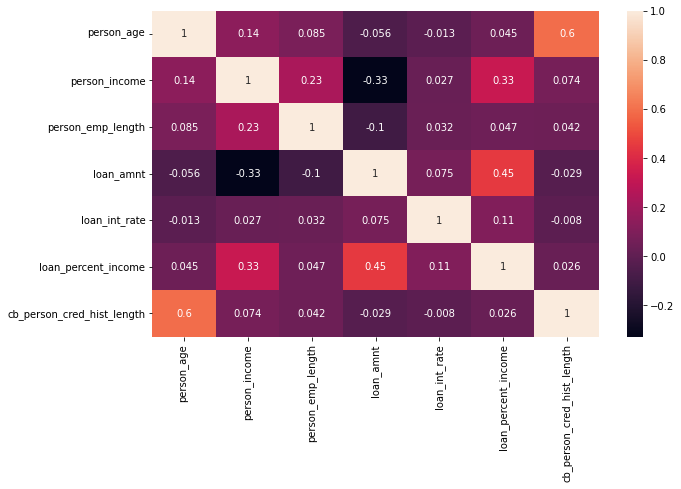

In [31]:
plt.figure(figsize = (10, 6))
sns.heatmap(out.corr(),annot = True)

In [32]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [33]:
X = out.iloc[:,:-1]
calc_vif(X)

,variables,VIF
0,person_age,1.024732
1,person_income,1.753347
2,person_emp_length,1.064695
3,loan_amnt,1.856163
4,loan_int_rate,1.022848
5,loan_percent_income,1.916366


## **Feature Selection**
**Here I will be removing the features with lesser predictive power and those which are correlated with some other independent variable(s).**

In [34]:
# out of loan_int_rate and loan_grade, loan_grade has more predictive power. That's why removing loan_int_rate
out.drop(['loan_int_rate', 'person_age', 'cb_person_cred_hist_length'], axis = 'columns', inplace = True)

### **Train Test Split**

In [35]:
X_train, X_test, y_train, y_test = train_test_split(out, target, test_size = 0.2, stratify = target, random_state = 0)

In [36]:
feature_cols = X_train.columns.tolist()
y_train = list(y_train)

### **Model Building**

In [37]:
model = sms.GLM(y_train, sms.add_constant(X_train[feature_cols]),family =Binomial(link=logit)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                25932
Model:                            GLM   Df Residuals:                    25927
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11559.
Date:                Sat, 03 Sep 2022   Deviance:                       23118.
Time:                        19:40:41   Pearson chi2:                 2.62e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.2797      0.017    -76.081      0.000      -1.313      -1.247
person_income          -0.6900      0.032    -21.534      0.000      -0.753      -0.627
person_emp_length      -0.5854      0.066     -8.902      0.000      -0.714      -0.457
loan_amnt              -0.1037      0.132     -0.786      0.432      -0.363       0.155
loan_percent_income    -0.8511      0.025    -33.421      0.000      -0.901      -0.801
=======================================================================================
"""

In [38]:
# loan_amnt has a p-value more than 0.05, hence it is not significant
feature_cols.remove('loan_amnt')
# feature_cols.remove('cb_person_default_on_file')

In [39]:
model = sms.GLM(y_train, sms.add_constant(X_train[feature_cols]),family =Binomial(link=logit) ).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                25932
Model:                            GLM   Df Residuals:                    25928
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11559.
Date:                Sat, 03 Sep 2022   Deviance:                       23119.
Time:                        19:40:42   Pearson chi2:                 2.62e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.2797      0.017    -76.089      0.000      -1.313      -1.247
person_income          -0.6755      0.026    -25.857      0.000      -0.727      -0.624
person_emp_length      -0.5845      0.066     -8.890      0.000      -0.713      -0.456
loan_percent_income    -0.8646      0.019    -46.009      0.000      -0.901      -0.828
=======================================================================================
"""

In [40]:
logreg = LogisticRegression(penalty = 'l1',tol = 1e-6,max_iter = int(1e6), solver='liblinear')
logreg.fit(X_train[feature_cols],y_train)

LogisticRegression(max_iter=1000000, penalty='l1', solver='liblinear',
                   tol=1e-06)

In [41]:
def create_scorecard(model,final_bin_info,feature_cols,basepoints = 340,pdo = 40):
    lr_df = pd.DataFrame({'variable':feature_cols,'estimate':model.coef_[0]})
    print("*"*50)
    print("Logistic Regression Coefficients")
    print("*"*50)
    print(lr_df)
    bin_info_pd = pd.DataFrame()
    for i in final_bin_info.keys():
        
        bin_info_i = pd.DataFrame(final_bin_info[i]['tbl'])
        bin_info_i['variable'] = i
        bin_info_pd = pd.concat([bin_info_pd,bin_info_i],ignore_index=True)
    bin_info_pd = bin_info_pd[['variable','bin','freq','bads','miss','rate','rule','woe','iv']]    
    bin_info_pd_lr = pd.merge(bin_info_pd[bin_info_pd['variable'].isin(feature_cols)],lr_df,how='left',on ='variable')
    bin_info_pd_lr['estimate_abs'] = np.abs(bin_info_pd_lr['estimate'])
    bin_info_pd_lr['woe_estimate'] = bin_info_pd_lr['woe']*bin_info_pd_lr['estimate_abs']
    bin_info_pd_lr['scaled_points'] = bin_info_pd_lr['woe_estimate']*(pdo/np.log(2))
    bin_info_min = bin_info_pd_lr.groupby(['variable'],as_index=False).agg({'scaled_points':'min'}).rename(columns = {'scaled_points':'adj_points'})
    bin_info_min['adj_points'] = np.where(bin_info_min['adj_points']>0,0,bin_info_min['adj_points'])
    bin_info_pd_lr = pd.merge(bin_info_pd_lr,
                              bin_info_min,
                              how='left',
                              on = 'variable')
    bin_info_pd_lr['rescaled_points'] = bin_info_pd_lr['scaled_points'] - bin_info_pd_lr['adj_points']
    
    bpts = pd.DataFrame({'variable':'intercept','estimate':model.intercept_[0]},index=[0])
    bpts['estimate_abs'] = np.abs(bpts['estimate'])
    bpts['scaled_points'] = bpts['estimate_abs']*(pdo/np.log(2))
    padj = bin_info_min['adj_points'].sum() 
    bpts['rescaled_points'] = bpts['scaled_points']+padj+basepoints
    
    for i in list(set(bin_info_pd_lr.columns)-set(bpts.columns)):
        bpts[i] = np.nan
    scorecard= pd.concat([bpts,bin_info_pd_lr],ignore_index=True)
    scorecard_final = scorecard[['variable','bin','freq','bads','miss','rate','rule','woe','iv','estimate','estimate_abs',\
          'woe_estimate','scaled_points','rescaled_points']]
    return(scorecard_final)

In [42]:
scorecard_final = create_scorecard(logreg,final_bin_info,feature_cols,basepoints = 340,pdo = 40)

**************************************************
Logistic Regression Coefficients
**************************************************
              variable  estimate
0        person_income -0.675237
1    person_emp_length -0.580420
2  loan_percent_income -0.864210


In [43]:
# final_bin_info

In [44]:
scorecard_final

,variable,bin,freq,bads,miss,rate,rule,woe,iv,estimate,estimate_abs,woe_estimate,scaled_points,rescaled_points
0,intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.279344,1.279344,NaN,73.828123,284.201628
1,person_income,1.0,4719.0,2163.0,0.0,0.4584,$X$ <= 31000,-1.1064,0.2259,-0.675237,0.675237,-0.747083,-43.112495,0.000000
2,person_income,2.0,4550.0,1325.0,0.0,0.2912,$X$ > 31000 and $X$ <= 40500,-0.3838,0.0229,-0.675237,0.675237,-0.259156,-14.955329,28.157167
3,person_income,3.0,4730.0,998.0,0.0,0.2110,$X$ > 40500 and $X$ <= 50000,0.0456,0.0003,-0.675237,0.675237,0.030791,1.776871,44.889366
4,person_income,4.0,4623.0,918.0,0.0,0.1986,$X$ > 50000 and $X$ <= 60000,0.1219,0.0020,-0.675237,0.675237,0.082311,4.750012,47.862507
5,person_income,5.0,4962.0,773.0,0.0,0.1558,$X$ > 60000 and $X$ <= 75000,0.4166,0.0235,-0.675237,0.675237,0.281304,16.233429,59.345924
6,person_income,6.0,4202.0,504.0,0.0,0.1199,$X$ > 75000 and $X$ <= 98850,0.7196,0.0539,-0.675237,0.675237,0.485901,28.040267,71.152762
7,person_income,7.0,4630.0,408.0,0.0,0.0881,$X$ > 98850,1.0635,0.1161,-0.675237,0.675237,0.718115,41.440834,84.553329
8,person_emp_length,0.0,887.0,281.0,887.0,0.3168,numpy.isnan($X$),-0.5048,0.0079,-0.580420,0.580420,-0.292996,-16.908156,0.000000
9,person_emp_length,1.0,6983.0,1946.0,0.0,0.2787,$X$ <= 1.0,-0.3223,0.0244,-0.580420,0.580420,-0.187069,-10.795362,6.112794


In [45]:
scorecard_final.to_csv("scorecard_final.csv",index = False)

In [46]:
def score_data_with_formula(input_df,model,feature_cols,basepoints=340,pdo=40):
    input_df['probability'] = model.predict_proba(input_df[feature_cols])[:,1]
    input_df['score'] = (basepoints) - (pdo*np.log((input_df['probability'])/(1-input_df['probability'])))/np.log(2)
    return(input_df)

In [47]:
woe_df_scored = score_data_with_formula(out,logreg,feature_cols)

In [48]:
woe_df_scored.loc[0,:]

person_income            0.121900
person_emp_length        0.355500
loan_amnt               -0.180500
loan_percent_income     -1.395700
probability              0.410520
score                  360.879679
Name: 0, dtype: float64

In [49]:
def score_data_with_scorecard(input_df,scorecard_final,feature_cols):
    input_df = input_df.reset_index()
    input_df2 = input_df[feature_cols+['index']].copy()
    melt_df = pd.melt(input_df2,id_vars= ['index']).rename(columns = {'value':'woe'})
    score_final = pd.merge(melt_df,\
                             scorecard_final[['variable','woe','rescaled_points']],\
                            how='inner',on = ['variable','woe'])
    score_final_row_level = score_final.groupby(['index'],as_index=False).agg({'rescaled_points':'sum'})
    
    score_final_row_level['score_by_scorecard'] = score_final_row_level['rescaled_points']+scorecard_final.head(1)['rescaled_points'].values[0]
    
    output_df = pd.merge(input_df,score_final_row_level[['index','score_by_scorecard']],how='left',on = ['index'])
    return(output_df)
    

In [50]:
output_df = score_data_with_scorecard(woe_df_scored,scorecard_final,feature_cols)

In [72]:
output_df = output_df.drop('index', axis = 'columns')

In [73]:
output_df.head()

,person_income,person_emp_length,loan_amnt,loan_percent_income,probability,score,score_by_scorecard
0,0.1219,0.3555,-0.1805,-1.3957,0.410520,360.879679,360.879679
1,-1.1064,0.1149,0.1881,0.6755,0.234563,408.252467,408.252467
2,-1.1064,-0.3223,0.1881,-1.3957,0.702867,290.314422,290.314422
3,0.4166,0.1149,-0.1805,-1.3957,0.396239,364.304256,364.304256
4,0.1219,0.2505,-0.1805,-1.3957,0.425344,357.362729,357.362729


In [74]:
output_df.describe()

,person_income,person_emp_length,loan_amnt,loan_percent_income,probability,score,score_by_scorecard
count,32416.000000,32416.000000,32416.000000,32416.000000,32416.000000,32416.000000,32416.000000
mean,0.118052,0.018200,0.009531,0.155966,0.218159,426.816088,426.816088
std,0.665294,0.255113,0.184214,0.786067,0.172088,55.503906,55.503906
min,-1.106400,-0.504800,-0.180500,-1.395700,0.053612,284.201628,284.201628
25%,-0.383800,-0.214700,-0.180500,0.162600,0.098757,396.186561,396.186561
50%,0.121900,0.114900,0.188100,0.448000,0.145809,442.019228,442.019228
75%,0.719600,0.250500,0.188100,0.675500,0.274156,467.598391,467.598391
max,1.063500,0.355500,0.188100,0.771900,0.724504,505.672261,505.672261


In [58]:
print("Logistic Regression f1 Score on training data",f1_score(y_train, logreg.predict(X_train[feature_cols])))
print("Logistic Regression ROC AUC Score on training data",roc_auc_score(y_train, logreg.predict(X_train[feature_cols])))
print("Logistic Regression Recall Score on training data",recall_score(y_train, logreg.predict(X_train[feature_cols])))

Logistic Regression f1 Score on training data 0.40906965871902756
Logistic Regression ROC AUC Score on training data 0.6262842990144197
Logistic Regression Recall Score on training data 0.30858755069652616


In [59]:
print("Logistic Regression f1 Score on testing data",f1_score(y_test, logreg.predict(X_test[feature_cols])))
print("Logistic Regression ROC AUC Score on testing data",roc_auc_score(y_test, logreg.predict(X_test[feature_cols])))
print("Logistic Regression Recall Score on testing data",recall_score(y_test, logreg.predict(X_test[feature_cols])))

Logistic Regression f1 Score on testing data 0.40206669798027245
Logistic Regression ROC AUC Score on testing data 0.6229854774522147
Logistic Regression Recall Score on testing data 0.3018335684062059


In [60]:
logreg.predict_proba(X_test[feature_cols])[:,1]

array([0.08637279, 0.59219792, 0.05678953, ..., 0.06661706, 0.22132404,
       0.06142029])

In [61]:
logreg.coef_[0]

array([-0.67523736, -0.58042   , -0.86420961])

In [62]:
feature_cols

['person_income', 'person_emp_length', 'loan_percent_income']

In [63]:
feature_imp = pd.DataFrame()
feature_imp['features'] = feature_cols
feature_imp['scores'] = logreg.coef_[0]

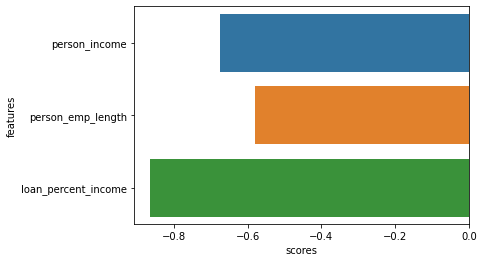

In [64]:
sns.barplot(x = 'scores', y = 'features', data = feature_imp)
plt.show()

In [65]:
ks_logit_train = pd.DataFrame()
ks_logit_train['probabilities'] = list(logreg.predict_proba(X_train[feature_cols])[:,1])
ks_logit_train['target'] = list(y_train)
ks_logit_train = ks_logit_train.sort_values(by="probabilities", ascending=False).reset_index(drop = True)

In [66]:
ks_logit_test = pd.DataFrame()
ks_logit_test['probabilities'] = list(logreg.predict_proba(X_test[feature_cols])[:,1])
ks_logit_test['target'] = list(y_test)
ks_logit_test = ks_logit_test.sort_values(by="probabilities", ascending=False).reset_index(drop = True)

In [67]:
def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10) #, duplicates='drop' 
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    print(kstable)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [68]:
data = ks(data = ks_logit_train, target = 'target', prob = 'probabilities')

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.518745  0.724504    1570        979     27.68%         4.83%   
2       0.353381  0.510147    1193       1427     21.04%         7.04%   
3       0.228054  0.350307     688       1733     12.13%         8.55%   
4       0.174690  0.227886     460       2305      8.11%        11.38%   
5       0.146291  0.173532     413       2180      7.28%        10.76%   
6       0.123754  0.145809     355       2207      6.26%        10.89%   
7       0.109073  0.123402     326       2288      5.75%        11.29%   
8       0.091970  0.108794     255       2257      4.50%        11.14%   
9       0.073780  0.091586     238       2422      4.20%        11.95%   
10      0.053612  0.073106     173       2463      3.05%        12.16%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             27.68

In [69]:
data = ks(data = ks_logit_test, target = 'target', prob = 'probabilities')

        min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                   
1       0.518745  0.724504     380        244     26.80%         4.82%   
2       0.338487  0.510147     307        364     21.65%         7.19%   
3       0.226637  0.330824     184        460     12.98%         9.08%   
4       0.173413  0.221324     113        530      7.97%        10.46%   
5       0.146291  0.173395      97        533      6.84%        10.52%   
6       0.122993  0.145809      82        571      5.78%        11.27%   
7       0.107926  0.122890      77        571      5.43%        11.27%   
8       0.090486  0.106918      76        590      5.36%        11.65%   
9       0.073780  0.087968      55        576      3.88%        11.37%   
10      0.053612  0.073106      47        627      3.31%        12.38%   

       cum_eventrate cum_noneventrate    KS  
Decile                                       
1             26.80